In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 16*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

1232


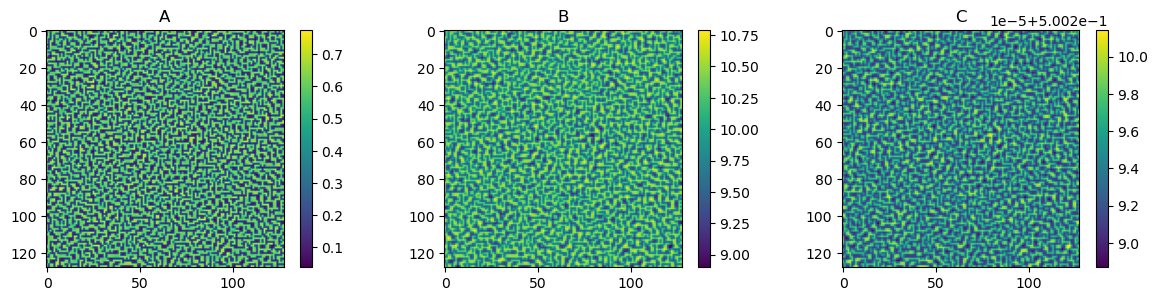

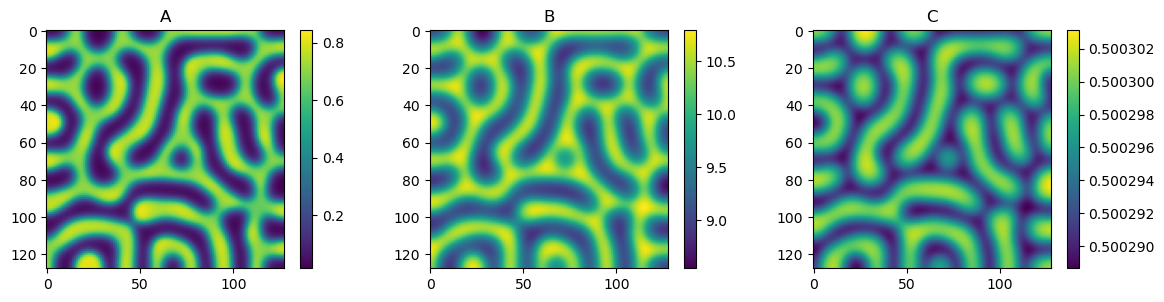

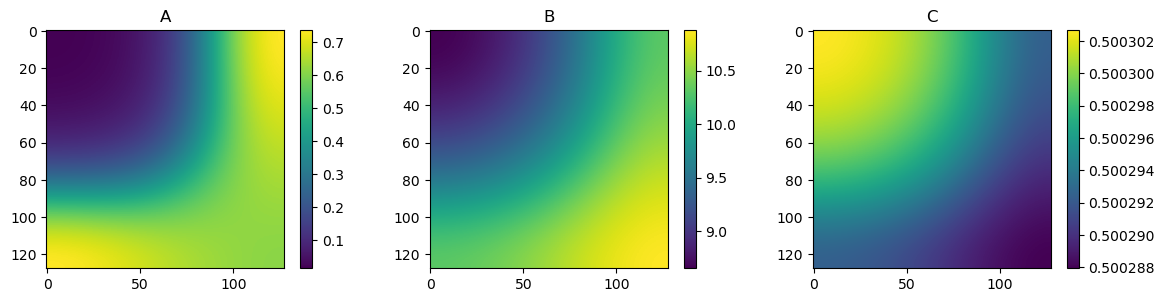

In [5]:
index = 2#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=10
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

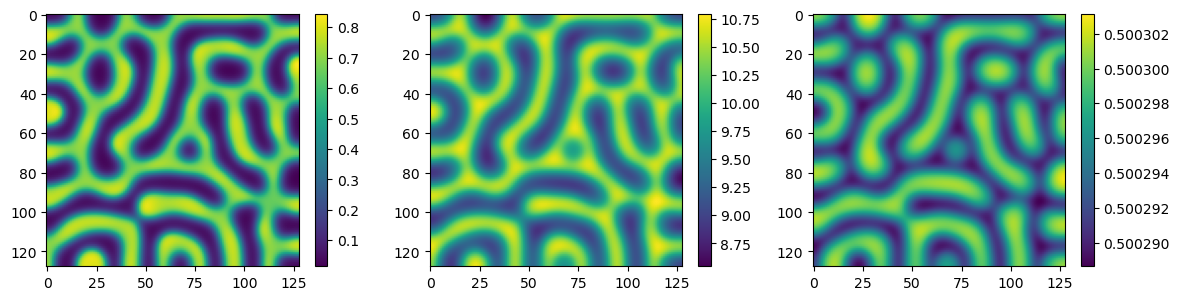

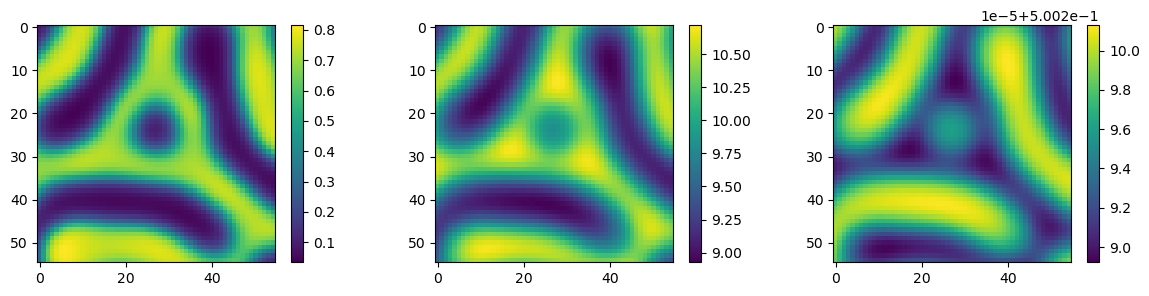

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [8]:
print(np.min(data[0, x_slice, y_slice, -1]), np.max(data[0, x_slice, y_slice, -1]))
print(np.min(data[1, x_slice, y_slice, -1]), np.max(data[1, x_slice, y_slice, -1]))
print(np.min(data[2, x_slice, y_slice, -1]), np.max(data[2, x_slice, y_slice, -1]))

0.03370782333236581 0.8158191948470113
8.926342734277082 10.721403520599122
0.5002892205940549 0.5003012949488828


In [9]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [10]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 4*1024, 4*1024, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs =  (A_xx + A_yy)# - u_t
            B_rhs =  (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + D_A * A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + D_B * B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs)
        
        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5)

In [11]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.001,
 'mu_A': 0.5,
 'V_A': 10.0,
 'K_AA': 0.5,
 'K_AB': 0.5,
 'K_AC': 5.0,
 'b_B': 0.1,
 'mu_B': 1.0,
 'V_B': 25.0,
 'K_BA': 5.0,
 'K_BC': 20.0,
 'b_C': 0.5,
 'mu_C': 1.0,
 'V_C': 50.0,
 'K_CB': 50.0,
 'K_CC': 10.0}

In [12]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-3,
D_A_val=tf_param("D_A",1 , False), D_B_val=tf_param("D_B", 1, False),
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 2, False),
V_A_val=tf_param("V_A", 15, False),V_B_val=tf_param("V_B", 30, False),
                                  V_C_val=tf_param("V_C", 90, False),
K_AA_val=tf_param("K_AA", 2, False),K_AB_val=tf_param("K_AB", 2, False),
K_AC_val=tf_param("K_AC", 2, False), K_BA_val=tf_param("K_BA", 1, False),
K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 90, False),
K_CC_val=tf_param("K_CC", 2, False),       
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=100, w5=100
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 1
D_B: 1
b_A: 1
b_B: 1
b_C: 2
V_A: 15
V_B: 30
V_C: 90
mu_A: 0.5
mu_B: 1.0
mu_C: 1.0
K_AA: 2
K_AB: 2
K_AC: 2
K_BA: 1
K_BC: 1
K_CB: 90
K_CC: 2
n: 4.0


In [13]:
epochs=20000+1
params_est = np.zeros((epochs, len(params_trainable1)))
def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = [item.numpy() for item in params_trainable1]

In [14]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
at epoch 0, total loss: 500628.41650390625
l2_res_A: 1797.99951172, l2_res_B: 211448.28125000, l2_res_C: 6318.08105469, l2_res_A_rhs: 89925.86718750, l2_res_B_rhs: 191138.18750000
D_A:0: 1.0009998083114624, D_B:0: 0.9990000128746033, b_A:0: 0.9989999532699585, b_B:0: 1.0010000467300415, b_C:0: 1.9989999532699585, V_A:0: 14.999001502990723, V_B:0: 30.000999450683594, V_C:0: 89.9990005493164, K_AA:0: 2.000999927520752, K_AB:0: 1.9989999532699585, K_AC:0: 1.999000906944275, K_BA:0: 0.9990000128746033, K_BC:0: 0.9989999532699585, K_CB:0: 90.00011444091797, K_CC:0: 2.000999927520752
Time taken: 16.21s

Start of epoch 200
at epoch 200, total loss: 376621.10546875
l2_res_A: 56256.83203125, l2_res_B: 313369.56250000, l2_res_C: 4785.87597656, l2_res_A_rhs: 1596.60058594, l2_res_B


Start of epoch 2400
at epoch 2400, total loss: 4703.381451129913
l2_res_A: 2.84566164, l2_res_B: 4409.13232422, l2_res_C: 21.68069458, l2_res_A_rhs: 173.70632935, l2_res_B_rhs: 96.01644135
D_A:0: 0.0002513824438210577, D_B:0: 0.872269868850708, b_A:0: 0.07456173002719879, b_B:0: 1.9318424463272095, b_C:0: 0.5879689455032349, V_A:0: 17.913150787353516, V_B:0: 30.477439880371094, V_C:0: 89.57534790039062, K_AA:0: 0.4471026360988617, K_AB:0: 0.6473198533058167, K_AC:0: 1.021953821182251, K_BA:0: 3.7292165756225586, K_BC:0: 0.46638166904449463, K_CB:0: 90.34571838378906, K_CC:0: 2.3982350826263428
Time taken: 41.07s

Start of epoch 2600
at epoch 2600, total loss: 4649.0192885398865
l2_res_A: 2.64562654, l2_res_B: 4229.96923828, l2_res_C: 9.13525867, l2_res_A_rhs: 256.74261475, l2_res_B_rhs: 150.52655029
D_A:0: 0.0, D_B:0: 0.8843268752098083, b_A:0: 0.0732671245932579, b_B:0: 1.923676609992981, b_C:0: 0.5571922659873962, V_A:0: 17.931087493896484, V_B:0: 30.34328842163086, V_C:0: 89.573257


Start of epoch 5200
at epoch 5200, total loss: 2595.099271601339
l2_res_A: 0.76563048, l2_res_B: 2382.31738281, l2_res_C: 0.00000007, l2_res_A_rhs: 129.76397705, l2_res_B_rhs: 82.25228119
D_A:0: 0.004072804469615221, D_B:0: 0.9357377886772156, b_A:0: 0.04241160303354263, b_B:0: 1.4467856884002686, b_C:0: 0.5002982020378113, V_A:0: 18.250720977783203, V_B:0: 28.092561721801758, V_C:0: 89.5701904296875, K_AA:0: 0.48723703622817993, K_AB:0: 0.5925110578536987, K_AC:0: 0.9222971200942993, K_BA:0: 4.009769916534424, K_BC:0: 0.45488810539245605, K_CB:0: 88.1927490234375, K_CC:0: 2.403402090072632
Time taken: 41.04s

Start of epoch 5400
at epoch 5400, total loss: 2184.725059807618
l2_res_A: 0.62326837, l2_res_B: 2111.79833984, l2_res_C: 0.00000006, l2_res_A_rhs: 51.01231003, l2_res_B_rhs: 21.29114151
D_A:0: 0.004651552531868219, D_B:0: 0.9412129521369934, b_A:0: 0.03841226175427437, b_B:0: 1.3746018409729004, b_C:0: 0.5002979040145874, V_A:0: 18.283960342407227, V_B:0: 27.903303146362305, V_


Start of epoch 8000
at epoch 8000, total loss: 264.3709062769055
l2_res_A: 0.01047457, l2_res_B: 145.42442322, l2_res_C: 0.00000003, l2_res_A_rhs: 72.01865387, l2_res_B_rhs: 46.91735458
D_A:0: 0.009834559634327888, D_B:0: 1.0116965770721436, b_A:0: 0.0023575900122523308, b_B:0: 0.17716901004314423, b_C:0: 0.5002955794334412, V_A:0: 18.557695388793945, V_B:0: 25.878826141357422, V_C:0: 89.5701904296875, K_AA:0: 0.5015785098075867, K_AB:0: 0.514610767364502, K_AC:0: 0.9220022559165955, K_BA:0: 4.254022598266602, K_BC:0: 0.45488810539245605, K_CB:0: 86.23860931396484, K_CC:0: 2.403402090072632
Time taken: 41.02s

Start of epoch 8200
at epoch 8200, total loss: 568.5357842259176
l2_res_A: 0.02577443, l2_res_B: 208.55763245, l2_res_C: 0.00000003, l2_res_A_rhs: 206.23301697, l2_res_B_rhs: 153.71936035
D_A:0: 0.009903011843562126, D_B:0: 1.014373779296875, b_A:0: 0.0018876580288633704, b_B:0: 0.11271616816520691, b_C:0: 0.5002955198287964, V_A:0: 18.560850143432617, V_B:0: 25.79266357421875, 


Start of epoch 10800
at epoch 10800, total loss: 184.23500962208772
l2_res_A: 0.01053373, l2_res_B: 54.47436523, l2_res_C: 0.00000003, l2_res_A_rhs: 76.60393524, l2_res_B_rhs: 53.14617538
D_A:0: 0.009978851303458214, D_B:0: 1.0111029148101807, b_A:0: 0.0013950237771496177, b_B:0: 0.00016893085557967424, b_C:0: 0.5002949237823486, V_A:0: 18.564964294433594, V_B:0: 25.287839889526367, V_C:0: 89.5701904296875, K_AA:0: 0.5018401741981506, K_AB:0: 0.5005103945732117, K_AC:0: 0.9211133122444153, K_BA:0: 4.259834289550781, K_BC:0: 0.4548923671245575, K_CB:0: 85.78836822509766, K_CC:0: 2.403402090072632
Time taken: 41.08s

Start of epoch 11000
at epoch 11000, total loss: 69.8157569447316
l2_res_A: 0.00672829, l2_res_B: 18.41124153, l2_res_C: 0.00000003, l2_res_A_rhs: 33.37348175, l2_res_B_rhs: 18.02430534
D_A:0: 0.009992258623242378, D_B:0: 1.0113766193389893, b_A:0: 0.0012523392215371132, b_B:0: 0.0, b_C:0: 0.5002949237823486, V_A:0: 18.564857482910156, V_B:0: 25.27492332458496, V_C:0: 89.57


Start of epoch 13600
at epoch 13600, total loss: 114.16370611279963
l2_res_A: 0.00833728, l2_res_B: 33.41150665, l2_res_C: 0.00000003, l2_res_A_rhs: 47.67752075, l2_res_B_rhs: 33.06634140
D_A:0: 0.00999151635915041, D_B:0: 1.0057311058044434, b_A:0: 0.0012652484001591802, b_B:0: 0.04971592500805855, b_C:0: 0.5002947449684143, V_A:0: 18.56421661376953, V_B:0: 25.137348175048828, V_C:0: 89.5701904296875, K_AA:0: 0.50164794921875, K_AB:0: 0.5000845789909363, K_AC:0: 0.9178910255432129, K_BA:0: 4.259727954864502, K_BC:0: 0.45500800013542175, K_CB:0: 85.71086120605469, K_CC:0: 2.403402090072632
Time taken: 41.15s

Start of epoch 13800
at epoch 13800, total loss: 43.71160771944909
l2_res_A: 0.00565790, l2_res_B: 11.57848740, l2_res_C: 0.00000003, l2_res_A_rhs: 20.84404755, l2_res_B_rhs: 11.28341484
D_A:0: 0.010003586299717426, D_B:0: 1.005190372467041, b_A:0: 0.0011754217557609081, b_B:0: 0.054255496710538864, b_C:0: 0.5002947449684143, V_A:0: 18.564674377441406, V_B:0: 25.124393463134766, 


Start of epoch 16400
at epoch 16400, total loss: 88.70073630202135
l2_res_A: 0.00594638, l2_res_B: 27.58323669, l2_res_C: 0.00000003, l2_res_A_rhs: 33.52600479, l2_res_B_rhs: 27.58554840
D_A:0: 0.01000251155346632, D_B:0: 0.9977537989616394, b_A:0: 0.001161883003078401, b_B:0: 0.12167224287986755, b_C:0: 0.5002947449684143, V_A:0: 18.563602447509766, V_B:0: 24.951271057128906, V_C:0: 89.5701904296875, K_AA:0: 0.5017317533493042, K_AB:0: 0.5000510215759277, K_AC:0: 0.9060060381889343, K_BA:0: 4.260640621185303, K_BC:0: 0.45548713207244873, K_CB:0: 85.62687683105469, K_CC:0: 2.403319835662842
Time taken: 41.05s

Start of epoch 16600
at epoch 16600, total loss: 86.52866021875563
l2_res_A: 0.00602187, l2_res_B: 27.32432365, l2_res_C: 0.00000003, l2_res_A_rhs: 31.76317406, l2_res_B_rhs: 27.43514061
D_A:0: 0.009961187839508057, D_B:0: 0.9970511198043823, b_A:0: 0.001487314933910966, b_B:0: 0.12669256329536438, b_C:0: 0.5002947449684143, V_A:0: 18.562175750732422, V_B:0: 24.93853187561035, V


Start of epoch 19200
at epoch 19200, total loss: 91.91800452283493
l2_res_A: 0.00609539, l2_res_B: 28.16031075, l2_res_C: 0.00000003, l2_res_A_rhs: 34.99850464, l2_res_B_rhs: 28.75309372
D_A:0: 0.00997402984648943, D_B:0: 0.9900305271148682, b_A:0: 0.0011523403227329254, b_B:0: 0.19369180500507355, b_C:0: 0.5002947449684143, V_A:0: 18.5612850189209, V_B:0: 24.766643524169922, V_C:0: 89.5701904296875, K_AA:0: 0.5015553832054138, K_AB:0: 0.5000844597816467, K_AC:0: 0.8675495386123657, K_BA:0: 4.260152339935303, K_BC:0: 0.45748448371887207, K_CB:0: 85.54557800292969, K_CC:0: 2.4024088382720947
Time taken: 41.03s

Start of epoch 19400
at epoch 19400, total loss: 49.619522786488986
l2_res_A: 0.00551004, l2_res_B: 15.28332138, l2_res_C: 0.00000003, l2_res_A_rhs: 18.81191826, l2_res_B_rhs: 15.51877308
D_A:0: 0.010009586811065674, D_B:0: 0.989535391330719, b_A:0: 0.001156385289505124, b_B:0: 0.19823044538497925, b_C:0: 0.5002947449684143, V_A:0: 18.561552047729492, V_B:0: 24.754056930541992, 

In [22]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.001, 'mu_A': 0.5, 'V_A': 10.0, 'K_AA': 0.5, 'K_AB': 0.5, 'K_AC': 5.0, 'b_B': 0.1, 'mu_B': 1.0, 'V_B': 25.0, 'K_BA': 5.0, 'K_BC': 20.0, 'b_C': 0.5, 'mu_C': 1.0, 'V_C': 50.0, 'K_CB': 50.0, 'K_CC': 10.0}


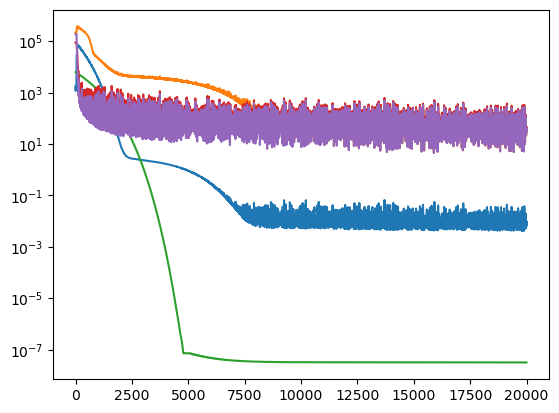

In [15]:
plt.plot(losses1)
plt.yscale('log')

In [23]:
epochs2=20000+1
params_est2 = np.zeros((epochs2, len(params_trainable1)))
def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = [item.numpy() for item in params_trainable1]

In [24]:
optimizer1.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [25]:
losses2 = tu.train(epochs=epochs2,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 102.79901780806517
l2_res_A: 0.00846945, l2_res_B: 30.71821785, l2_res_C: 0.00000003, l2_res_A_rhs: 41.14606857, l2_res_B_rhs: 30.92626190
D_A:0: 0.009978124871850014, D_B:0: 0.9878562688827515, b_A:0: 0.0012171802809461951, b_B:0: 0.21214944124221802, b_C:0: 0.5002947449684143, V_A:0: 18.561193466186523, V_B:0: 24.715816497802734, V_C:0: 89.5701904296875, K_AA:0: 0.5017504692077637, K_AB:0: 0.5000079870223999, K_AC:0: 0.8475695848464966, K_BA:0: 4.260477542877197, K_BC:0: 0.45883604884147644, K_CB:0: 85.52351379394531, K_CC:0: 2.4017910957336426
Time taken: 0.26s

Start of epoch 200
at epoch 200, total loss: 13.845398282290638
l2_res_A: 0.00414044, l2_res_B: 2.82627225, l2_res_C: 0.00000003, l2_res_A_rhs: 8.14171982, l2_res_B_rhs: 2.87326574
D_A:0: 0.010013769380748272, D_B:0: 0.9880325794219971, b_A:0: 0.0010969246504828334, b_B:0: 0.21108531951904297, b_C:0: 0.5002947449684143, V_A:0: 18.56151008605957, V_B:0: 24.715288162231445, V_C:0: 89.5


Start of epoch 2800
at epoch 2800, total loss: 11.461081141624842
l2_res_A: 0.00400027, l2_res_B: 2.30824709, l2_res_C: 0.00000003, l2_res_A_rhs: 6.80296850, l2_res_B_rhs: 2.34586525
D_A:0: 0.010012635961174965, D_B:0: 0.9880968928337097, b_A:0: 0.0010955925099551678, b_B:0: 0.20959779620170593, b_C:0: 0.5002948045730591, V_A:0: 18.56146240234375, V_B:0: 24.714195251464844, V_C:0: 89.5701904296875, K_AA:0: 0.5017038583755493, K_AB:0: 0.49990057945251465, K_AC:0: 0.8374813199043274, K_BA:0: 4.2608256340026855, K_BC:0: 0.460104376077652, K_CB:0: 85.5234146118164, K_CC:0: 2.4012303352355957
Time taken: 41.02s

Start of epoch 3000
at epoch 3000, total loss: 11.32841762669862
l2_res_A: 0.00398737, l2_res_B: 2.29885507, l2_res_C: 0.00000003, l2_res_A_rhs: 6.68753099, l2_res_B_rhs: 2.33804417
D_A:0: 0.010013791732490063, D_B:0: 0.9880818128585815, b_A:0: 0.0010889237746596336, b_B:0: 0.2096569687128067, b_C:0: 0.5002948045730591, V_A:0: 18.561447143554688, V_B:0: 24.714061737060547, V_C:0: 8


Start of epoch 5600
at epoch 5600, total loss: 9.311837634738083
l2_res_A: 0.00382428, l2_res_B: 1.87631905, l2_res_C: 0.00000003, l2_res_A_rhs: 5.51551247, l2_res_B_rhs: 1.91618180
D_A:0: 0.010001469403505325, D_B:0: 0.9879131317138672, b_A:0: 0.0010961228981614113, b_B:0: 0.2113417536020279, b_C:0: 0.5002946257591248, V_A:0: 18.561227798461914, V_B:0: 24.710371017456055, V_C:0: 89.5701904296875, K_AA:0: 0.501694917678833, K_AB:0: 0.4999125003814697, K_AC:0: 0.8243130445480347, K_BA:0: 4.26084041595459, K_BC:0: 0.46524184942245483, K_CB:0: 85.5234146118164, K_CC:0: 2.399022340774536
Time taken: 41.16s

Start of epoch 5800
at epoch 5800, total loss: 15.224055148801732
l2_res_A: 0.00426418, l2_res_B: 3.68656540, l2_res_C: 0.00000003, l2_res_A_rhs: 7.85643721, l2_res_B_rhs: 3.67678833
D_A:0: 0.010014314204454422, D_B:0: 0.987891674041748, b_A:0: 0.0011050731409341097, b_B:0: 0.21149411797523499, b_C:0: 0.5002946853637695, V_A:0: 18.561172485351562, V_B:0: 24.710079193115234, V_C:0: 89.5


Start of epoch 8400
at epoch 8400, total loss: 8.480784773149146
l2_res_A: 0.00376591, l2_res_B: 1.76300681, l2_res_C: 0.00000003, l2_res_A_rhs: 4.92560911, l2_res_B_rhs: 1.78840292
D_A:0: 0.01001797802746296, D_B:0: 0.9877406358718872, b_A:0: 0.0010888974647969007, b_B:0: 0.21297451853752136, b_C:0: 0.5002942085266113, V_A:0: 18.560976028442383, V_B:0: 24.706438064575195, V_C:0: 89.5701904296875, K_AA:0: 0.5017026662826538, K_AB:0: 0.499916672706604, K_AC:0: 0.808831512928009, K_BA:0: 4.260838508605957, K_BC:0: 0.48487669229507446, K_CB:0: 85.5234146118164, K_CC:0: 2.3914237022399902
Time taken: 41.04s

Start of epoch 8600
at epoch 8600, total loss: 9.288845636097946
l2_res_A: 0.00396302, l2_res_B: 2.07401729, l2_res_C: 0.00000007, l2_res_A_rhs: 5.14366388, l2_res_B_rhs: 2.06720138
D_A:0: 0.010014393366873264, D_B:0: 0.9877284169197083, b_A:0: 0.001086515374481678, b_B:0: 0.21310625970363617, b_C:0: 0.5002902150154114, V_A:0: 18.560949325561523, V_B:0: 24.70616912841797, V_C:0: 89.57


Start of epoch 11200
at epoch 11200, total loss: 8.317284969351832
l2_res_A: 0.00375819, l2_res_B: 1.77361846, l2_res_C: 0.00000003, l2_res_A_rhs: 4.74057436, l2_res_B_rhs: 1.79933393
D_A:0: 0.010013692080974579, D_B:0: 0.9875571131706238, b_A:0: 0.0010879839537665248, b_B:0: 0.2146974354982376, b_C:0: 0.5002942681312561, V_A:0: 18.560754776000977, V_B:0: 24.70246124267578, V_C:0: 89.5701904296875, K_AA:0: 0.5016995668411255, K_AB:0: 0.4999234080314636, K_AC:0: 0.7881195545196533, K_BA:0: 4.260848522186279, K_BC:0: 0.5396910905838013, K_CB:0: 85.5234146118164, K_CC:0: 2.370378255844116
Time taken: 41.05s

Start of epoch 11400
at epoch 11400, total loss: 7.488756535544457
l2_res_A: 0.00369761, l2_res_B: 1.53669989, l2_res_C: 0.00000003, l2_res_A_rhs: 4.39373589, l2_res_B_rhs: 1.55462313
D_A:0: 0.010013329796493053, D_B:0: 0.9875485301017761, b_A:0: 0.0010948446579277515, b_B:0: 0.21479591727256775, b_C:0: 0.5002938508987427, V_A:0: 18.56074333190918, V_B:0: 24.702180862426758, V_C:0: 8


Start of epoch 14000
at epoch 14000, total loss: 9.309891913926936
l2_res_A: 0.00395267, l2_res_B: 2.03809118, l2_res_C: 0.00000004, l2_res_A_rhs: 5.20214844, l2_res_B_rhs: 2.06569958
D_A:0: 0.009997866116464138, D_B:0: 0.9874092936515808, b_A:0: 0.0011384099489077926, b_B:0: 0.2160973846912384, b_C:0: 0.5002896189689636, V_A:0: 18.560470581054688, V_B:0: 24.69889259338379, V_C:0: 89.5701904296875, K_AA:0: 0.5016689896583557, K_AB:0: 0.49992403388023376, K_AC:0: 0.7562941312789917, K_BA:0: 4.260898590087891, K_BC:0: 0.6194836497306824, K_CB:0: 85.5234146118164, K_CC:0: 2.3315465450286865
Time taken: 41.21s

Start of epoch 14200
at epoch 14200, total loss: 6.211402218379806
l2_res_A: 0.00365474, l2_res_B: 1.23385286, l2_res_C: 0.00000002, l2_res_A_rhs: 3.71414113, l2_res_B_rhs: 1.25975347
D_A:0: 0.010013098828494549, D_B:0: 0.9873981475830078, b_A:0: 0.0010888847755268216, b_B:0: 0.21618884801864624, b_C:0: 0.5002902150154114, V_A:0: 18.56043243408203, V_B:0: 24.698659896850586, V_C:0:


Start of epoch 16800
at epoch 16800, total loss: 5.6583371140990835
l2_res_A: 0.00364401, l2_res_B: 1.11666381, l2_res_C: 0.00000010, l2_res_A_rhs: 3.41653705, l2_res_B_rhs: 1.12149215
D_A:0: 0.010015788488090038, D_B:0: 0.9872695803642273, b_A:0: 0.001084987772628665, b_B:0: 0.21739229559898376, b_C:0: 0.5002967715263367, V_A:0: 18.560169219970703, V_B:0: 24.695642471313477, V_C:0: 89.5701904296875, K_AA:0: 0.5016946792602539, K_AB:0: 0.49992597103118896, K_AC:0: 0.7166224122047424, K_BA:0: 4.260890483856201, K_BC:0: 0.693795382976532, K_CB:0: 85.5234146118164, K_CC:0: 2.286055564880371
Time taken: 41.10s

Start of epoch 17000
at epoch 17000, total loss: 6.160318758726053
l2_res_A: 0.00376524, l2_res_B: 1.25648069, l2_res_C: 0.00000001, l2_res_A_rhs: 3.66164970, l2_res_B_rhs: 1.23842311
D_A:0: 0.010014047846198082, D_B:0: 0.9872595071792603, b_A:0: 0.00108907010871917, b_B:0: 0.21750573813915253, b_C:0: 0.5002889633178711, V_A:0: 18.560157775878906, V_B:0: 24.695411682128906, V_C:0: 


Start of epoch 19600
at epoch 19600, total loss: 7.675057310126707
l2_res_A: 0.00363589, l2_res_B: 1.72955203, l2_res_C: 0.00000001, l2_res_A_rhs: 4.16446352, l2_res_B_rhs: 1.77740586
D_A:0: 0.010014061816036701, D_B:0: 0.9871435761451721, b_A:0: 0.0010918561602011323, b_B:0: 0.21850024163722992, b_C:0: 0.5002915263175964, V_A:0: 18.559955596923828, V_B:0: 24.69281768798828, V_C:0: 89.5701904296875, K_AA:0: 0.5016911625862122, K_AB:0: 0.4999223053455353, K_AC:0: 0.6873145699501038, K_BA:0: 4.2609076499938965, K_BC:0: 0.7413358092308044, K_CB:0: 85.5234146118164, K_CC:0: 2.252650499343872
Time taken: 41.11s

Start of epoch 19800
at epoch 19800, total loss: 7.2183553994434995
l2_res_A: 0.00391695, l2_res_B: 1.39107573, l2_res_C: 0.00000001, l2_res_A_rhs: 4.38995361, l2_res_B_rhs: 1.43340909
D_A:0: 0.010013137012720108, D_B:0: 0.9871305227279663, b_A:0: 0.0010838955640792847, b_B:0: 0.2186109572649002, b_C:0: 0.5002884268760681, V_A:0: 18.559925079345703, V_B:0: 24.692607879638672, V_C:0

In [ ]:
'D_A': 0.01, 'D_B': 1.0, 'b_A': 0.001, 'b_B': 0.1, 'b_C': 0.5, 
'V_A': 10.0, 'V_B': 25.0, 'V_C': 50.0,
'K_AA': 0.5, 'K_AB': 0.5, 'K_AC': 5.0, 'K_BA': 5.0, 
'K_BC': 20.0, 'K_CB': 50.0, 'K_CC': 10.0

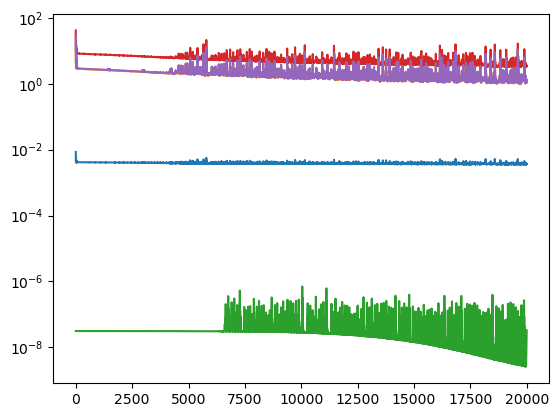

In [26]:
plt.plot(losses2)
plt.yscale('log')

In [27]:
(D_A_val, D_B_val, b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = params_trainable1

In [28]:
(n_val, D_A_val, D_B_val,
 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = (params["n"], D_A_val, D_B_val,
                         b_A_val, b_B_val, b_C_val,
                         V_A_val, V_B_val, V_C_val,
                         params["mu_A"], params["mu_B"], params["mu_C"],
                         K_AA_val, K_AB_val, K_AC_val, 
                         K_BA_val, K_BC_val, 
                         K_CB_val, K_CC_val)

In [29]:
with open(f"./parameters_temp.npy", "wb") as f:
    np.save(f, (n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val))

In [30]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = D_A_val#params["D_A"]
D_B = D_B_val#params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [31]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der[1:-1,1:-1]-actual_A_der[1:-1,1:-1])**2))
    print(np.sum((B_der[1:-1,1:-1]-actual_B_der[1:-1,1:-1])**2))


    plot_n_im([to(A_xx)[1:-1,1:-1], c_xx[0,x_slice, y_slice , -1],
               to(A_yy)[1:-1,1:-1], c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx)[1:-1,1:-1], c_xx[1,x_slice, y_slice  , -1], 
               to(B_yy)[1:-1,1:-1], c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

0.00035869912
1.2519647


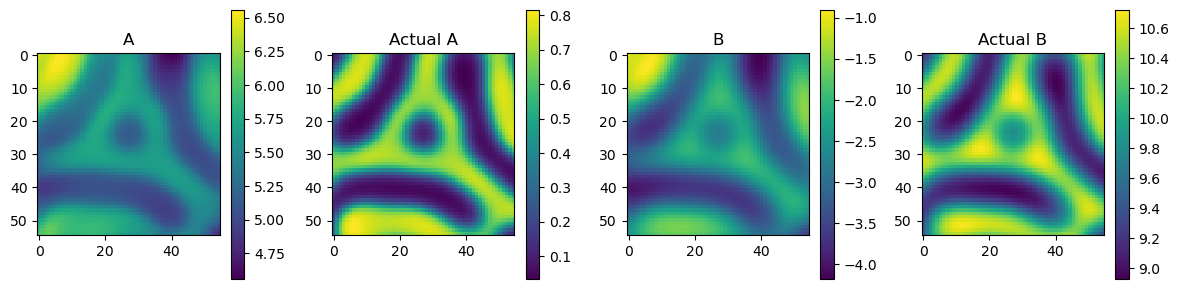

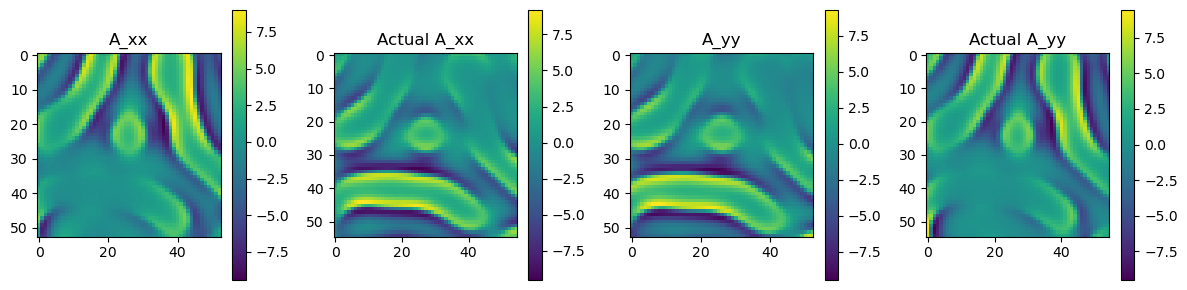

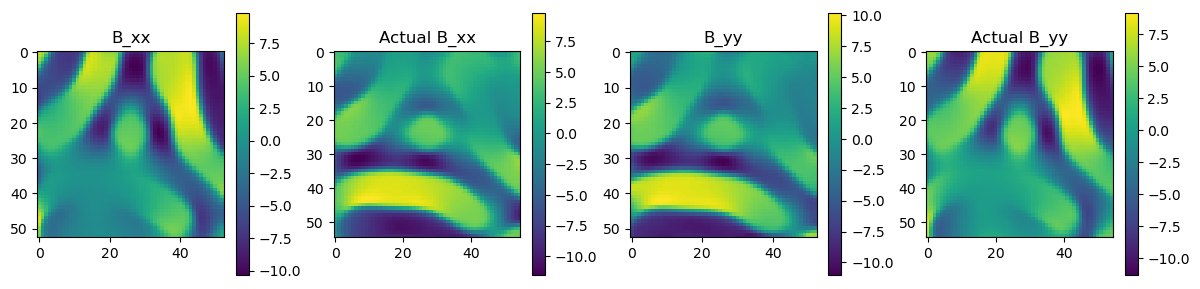

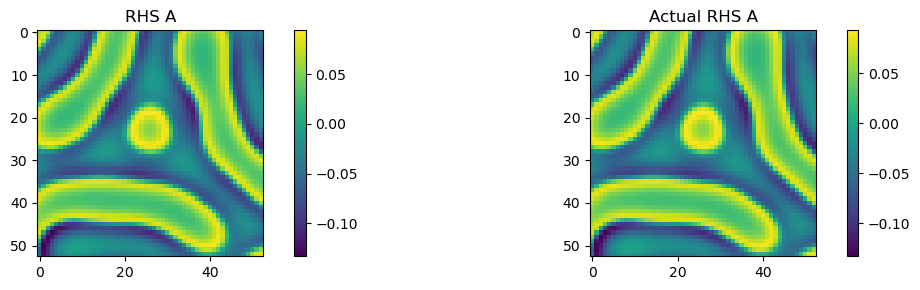

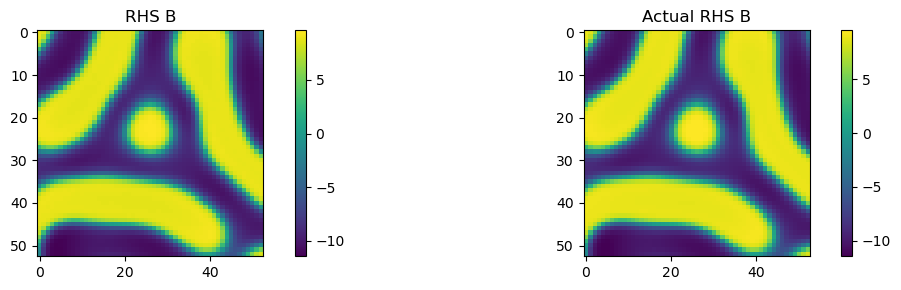

In [32]:
plot_state(pinn1)

In [48]:
def ratio(nom, dnom, n=2):
    return (nom / (dnom + 1e-20)) ** (n)
    
def act(x, km, n=2):
    return 1 / (1 + (km / (x + 1e-20)) ** (n))

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-20)) ** (n))

A = c[0,:, : , -1]
B = c[1,:, : , -1]
C = c[1,:, : , -1]

# f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
# f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
# f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C

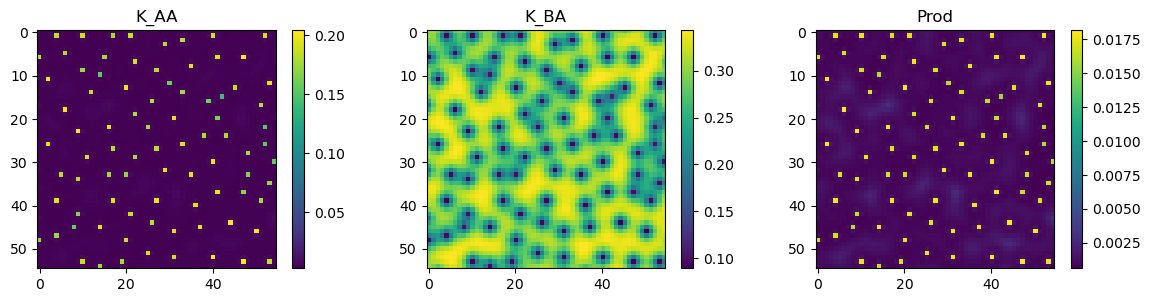

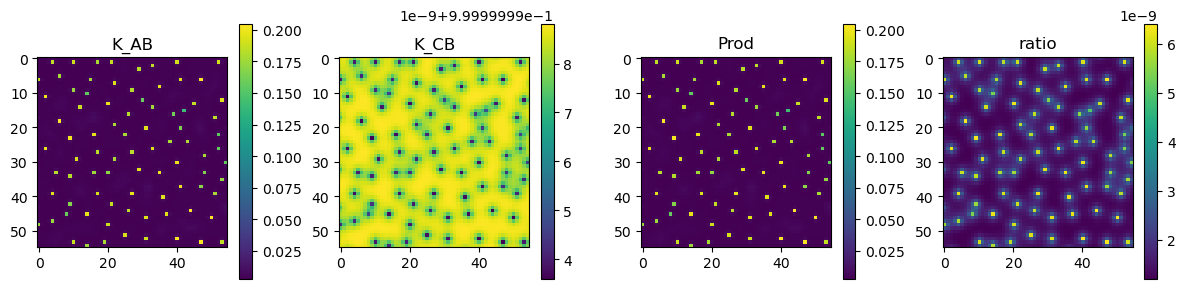

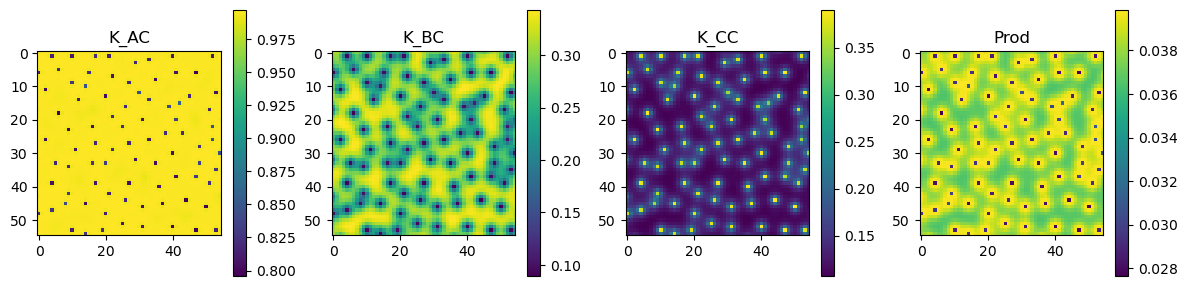

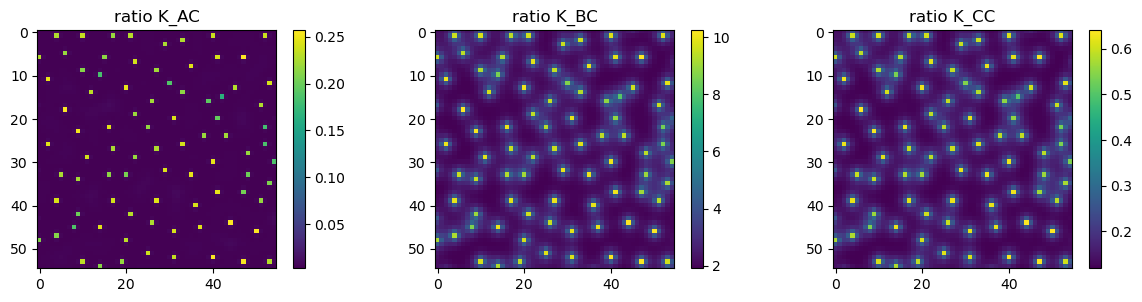

In [50]:
n = params["n"]
plot_n_im([act(A, params["K_AA"], n), inh(B, params["K_BA"], n), 
           act(A, params["K_AA"], n)*inh(B, params["K_BA"], n)],
          ["K_AA", "K_BA", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([act(A, params["K_AB"], n), inh(C, params["K_CB"], n), 
           act(A, params["K_AB"], n)*inh(C, params["K_CB"], n), ratio(C, params["K_CB"], n)],
          ["K_AB", "K_CB", "Prod", "ratio"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([inh(A, params["K_AC"], n), inh(B, params["K_BC"], n), act(C, params["K_CC"], n),
           inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n)],
          ["K_AC", "K_BC", "K_CC", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([ratio(A, params["K_AC"], n), ratio(B, params["K_BC"], n), ratio(C, params["K_CC"], n)],
          ["ratio K_AC", "ratio K_BC", "ratio K_CC"],
              figsize=(12, 3)); plt.tight_layout()